# TMDB Box Office Prediction

In [1]:
# import all the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pprint
import json
from xgboost import XGBRegressor
import warnings
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings("ignore")

In [2]:
# read the train and the test file
train = pd.read_csv('tmdb-box-office-prediction/train.csv')
test = pd.read_csv('tmdb-box-office-prediction/test.csv')
print('The shape of the train dataset is : '+str(train.shape))
print('The shape of the test dataset is : '+str(test.shape))


The shape of the train dataset is : (3000, 23)
The shape of the test dataset is : (4398, 22)


# Part 1 - Data Cleaning and Reformatting

In [3]:
# fixing the ambiguity in the data
def date_fix(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year
    
test.loc[test['release_date'].isna(),'release_date'] = '01/01/98'
train['release_date'] = train['release_date'].astype(str).apply(lambda x: date_fix(x))
test['release_date'] = test['release_date'].astype(str).apply(lambda x: date_fix(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [4]:
test[test['release_date'].isnull()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew


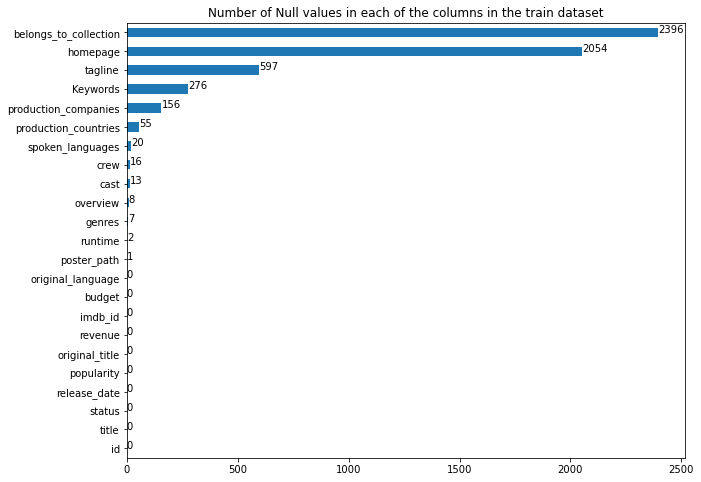

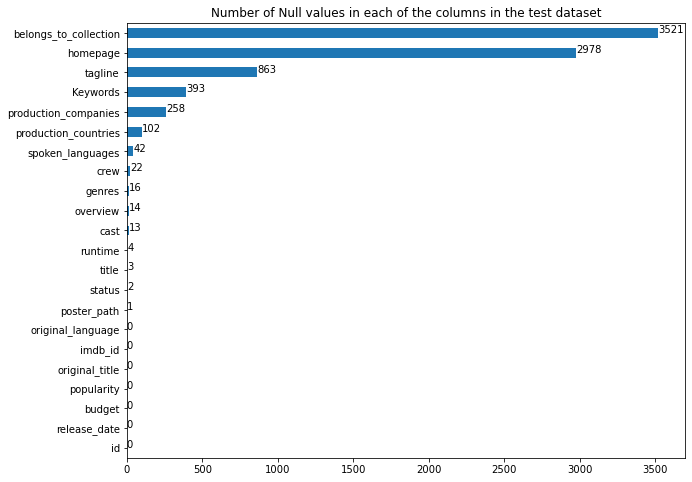

In [5]:
# TODO: code for data cleaning and reformatting
%matplotlib inline

# Find the number of NULL values in each of the column in the train dataset
plt.figure(figsize=(10,8))
plt.title('Number of Null values in each of the columns in the train dataset')
train_null = train.isna().sum().sort_values(ascending=True)
train_null.plot(kind='barh')
for index, value in enumerate(train_null):
    plt.text(value, index, str(value))

# Find the number of NULL values in each of the column in the test dataset
plt.figure(figsize=(10,8))
plt.title('Number of Null values in each of the columns in the test dataset')
test_null = test.isna().sum().sort_values(ascending=True)
test_null.plot(kind='barh')
for index, value in enumerate(test_null):
    plt.text(value, index, str(value))

In [6]:

def retrieve_info(s):
    try:
        info = eval(s)
    except:
        info = {}
    return info

# replace the null values with empty strings for these columns in both the train and the test set
train['homepage'] = train['homepage'].fillna("")
train['tagline'] = train['tagline'].fillna("")
train['poster_path'] = train['poster_path'].fillna("")

test['homepage'] = test['homepage'].fillna("")
test['tagline'] = test['tagline'].fillna("")
test['poster_path'] = test['poster_path'].fillna("")


# columns which has both has json and dictionary values
json_cols = ['belongs_to_collection','genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# Extract necessary information from the json and dictionary values in the dataset
train = train.replace(np.nan, {column: {} for column in json_cols})
train['genres'] = train['genres'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['collection_name'] = train['belongs_to_collection'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['production_companies_name'] = train['production_companies'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['production_country_name'] = train['production_countries'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['language_spoken'] = train['spoken_languages'].map(lambda x: sorted([info['iso_639_1'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['keywords'] = train['Keywords'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['cast_gender'] = train['cast'].map(lambda x: sorted([info['gender'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['crew_department'] = train['crew'].map(lambda x: sorted([info['department'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['crew_gender'] = train['crew'].map(lambda x: sorted([info['gender'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['cast_names'] = train['cast'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
train['cast_roles'] = train['cast'].map(lambda x: sorted([info['character'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))

# extract necessary information from the dictionaries and lists in the test set
test = test.replace(np.nan, {column: {} for column in json_cols})
test['genres'] = test['genres'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['collection_name'] = test['belongs_to_collection'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['production_companies_name'] = test['production_companies'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['production_country_name'] = test['production_countries'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['language_spoken'] = test['spoken_languages'].map(lambda x: sorted([info['iso_639_1'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['keywords'] = test['Keywords'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['cast_gender'] = test['cast'].map(lambda x: sorted([info['gender'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['crew_department'] = test['crew'].map(lambda x: sorted([info['department'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['crew_gender'] = test['crew'].map(lambda x: sorted([info['gender'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['cast_names'] = test['cast'].map(lambda x: sorted([info['name'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))
test['cast_roles'] = test['cast'].map(lambda x: sorted([info['character'] for info in retrieve_info(x)])).map(lambda x: ','.join(map(str, x)))


In [7]:
train.isna().sum()

id                           0
belongs_to_collection        0
budget                       0
genres                       0
homepage                     0
imdb_id                      0
original_language            0
original_title               0
overview                     8
popularity                   0
poster_path                  0
production_companies         0
production_countries         0
release_date                 0
runtime                      2
spoken_languages             0
status                       0
tagline                      0
title                        0
Keywords                     0
cast                         0
crew                         0
revenue                      0
collection_name              0
production_companies_name    0
production_country_name      0
language_spoken              0
keywords                     0
cast_gender                  0
crew_department              0
crew_gender                  0
cast_names                   0
cast_rol

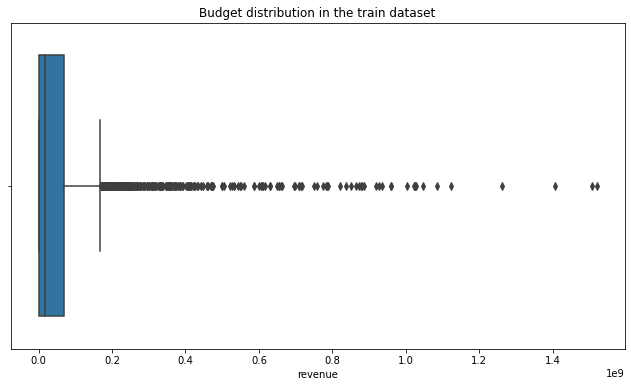

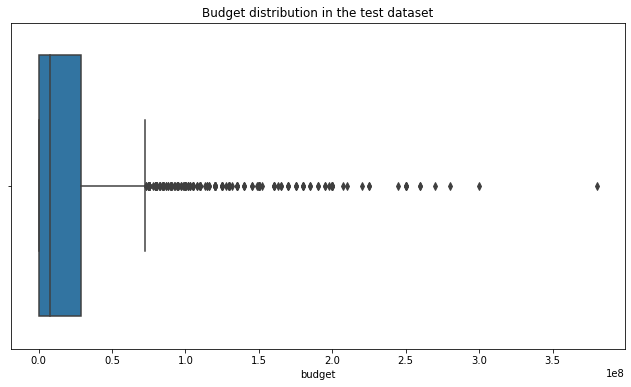

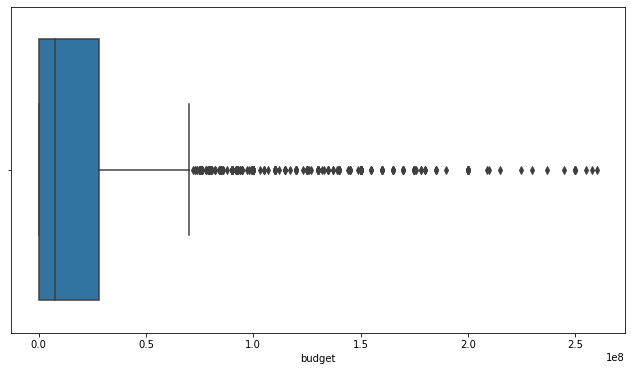

In [8]:
plt.figure(figsize=(11,6))
plt.title('Revenue distribution in the train dataset')
sns.boxplot(train['revenue'])

plt.title('Budget distribution in the train dataset')
plt.figure(figsize=(11,6))
sns.boxplot(train['budget'])

plt.title('Budget distribution in the test dataset')
plt.figure(figsize=(11,6))
sns.boxplot(test['budget'])

### Observations
- Fixing the date column, replacing incorrect year with the correct year with the help of range release dates.
- Imputing missing values.
    - Nan values in columns like homepage, tagline, poster_path are replaced with empty strings
    - Nan values in columns with jsons and dictionaries are replaced with empty dictionary
- The values in the json and dictionary in different column is extracted using eval() method
- There seems to be no outlier in the revenue and the budget columns, which is evident from the boxplots above.

# Part 2 - Word Cloud

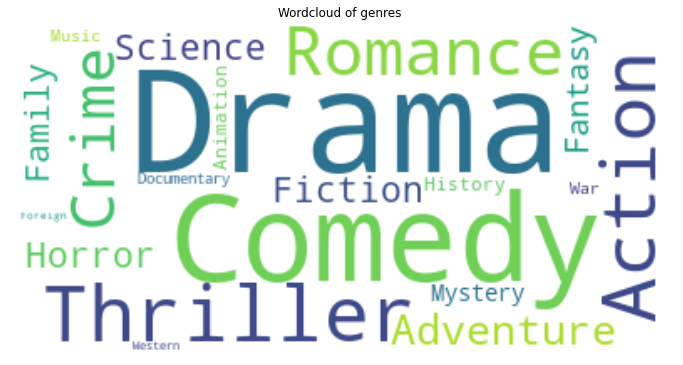

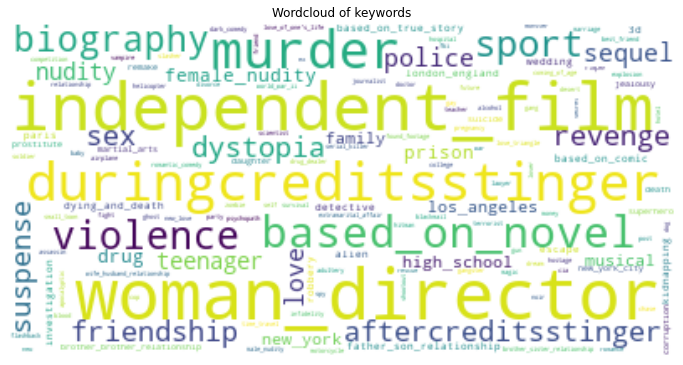

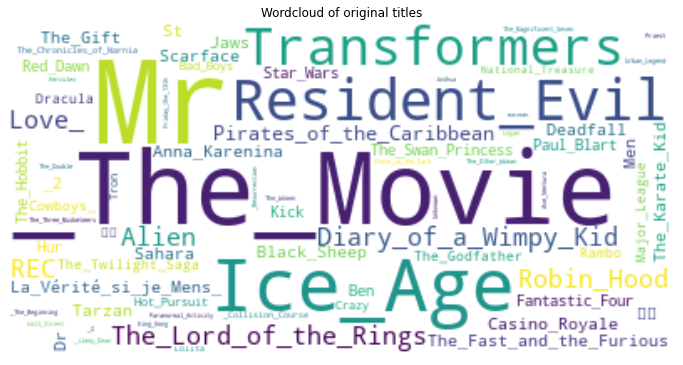

{'otherwise', "wasn't", 'against', "wouldn't", 'else', "you're", "where's", "she's", 'there', 'www', 'under', 'then', 'as', "they've", 'your', 'had', 'them', 'when', 'yourself', "hadn't", 'his', 'com', 'is', 'r', 'am', "mustn't", 'those', 'which', 'have', 'hers', 'also', 'about', 'cannot', 'been', 'we', "we've", 'both', 'during', 'has', 'ours', 'through', "we'd", 'any', "can't", 'does', 'very', 'their', 'few', 'same', 'so', 'from', 'with', 'by', 'it', 'ourselves', "isn't", 'you', 'hence', 'did', 'having', 'himself', 'should', 'who', 'theirs', 'be', "what's", 'doing', 'could', 'further', 'of', 'ever', 'once', 'would', "you'll", 'to', "doesn't", 'ought', "they're", "didn't", 'only', "he'll", 'are', 'at', 'can', "we'll", 'all', 'him', "that's", 'http', 'since', 'on', 'the', "they'd", "weren't", "won't", "i'm", 'where', 'like', 'own', 'not', 'most', 'shall', 'again', 'what', 'but', 'yourselves', 'why', "she'll", 'in', 'my', 'too', "i've", "couldn't", 'a', 'k', 'out', 'below', "when's", 'he

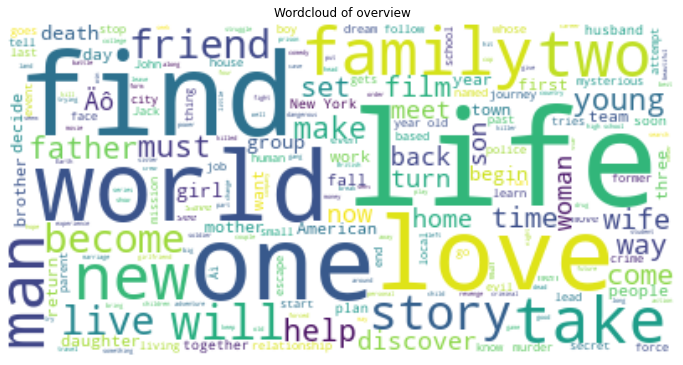

In [9]:
# TODO: code for generating word clouds
plt.figure(figsize=(12,12))
genres = train['genres'].apply(lambda x: ' '.join(x.split(',')))
wordcloud_genres = WordCloud(collocations=False,background_color='white').generate(' '.join(genres.values))
plt.title('Wordcloud of genres ')
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(12,16))
keywords = train['keywords'].apply(lambda x: '_'.join(x.split(' ')))
wordcloud_keywords = WordCloud(collocations=False,background_color='white').generate(' '.join(keywords.values))
plt.title('Wordcloud of keywords')
plt.imshow(wordcloud_keywords, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(12,16))
titles = train['original_title'].apply(lambda x: '_'.join(x.split(' ')))
wordcloud_titles = WordCloud(collocations=False,background_color='white').generate(' '.join(titles.values))
plt.title('Wordcloud of original titles')
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
print(stopwords)
plt.figure(figsize=(12,16))
wordcloud_overview = WordCloud(stopwords=stopwords,collocations=True,background_color='white').generate(' '.join(train['overview'].astype(str).values))
plt.title('Wordcloud of overview')
plt.imshow(wordcloud_overview, interpolation='bilinear')
plt.axis("off")
plt.show()



### Observations
- The top three generes observed in the first word cloud are Drama, Comedy, Thriller
- The top three generes observed in the second word cloud are women director, independent film, murder
- The top three titles observed in the third word cloud are Mr, The Movie, Resident Evil
- The top three words in overview column observed in the fourth word cloud are life, love, find

# Part 3 - Time Series Analysis

In [10]:
# TODO: code for time series analysis

# extract the year, month, day and quarter of the release from release 

train['release_year'] = pd.DatetimeIndex(train['release_date']).year
train['release_month'] = pd.DatetimeIndex(train['release_date']).month
train['release_day'] = train['release_date'].dt.day_name()
train['release_quarter'] = train['release_date'].dt.quarter

test['release_year'] = pd.DatetimeIndex(test['release_date']).year
test['release_month'] = pd.DatetimeIndex(test['release_date']).month
test['release_day'] = test['release_date'].dt.day_name()
test['release_quarter'] = test['release_date'].dt.quarter


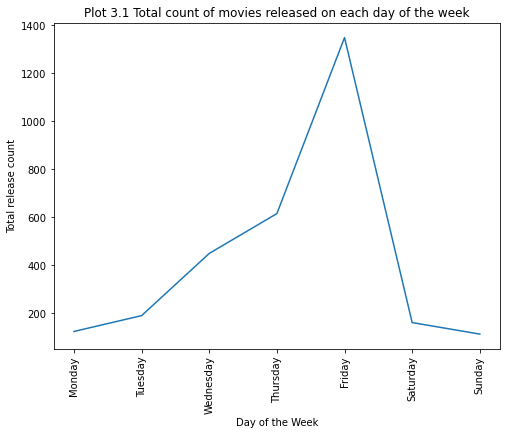

In [11]:
# Plot of the total count of movies released on each day of the week

sorter_day = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
release_each_day = train.groupby('release_day').size().reset_index().rename(columns={0:'count'})
sorterIndex = dict(zip(sorter_day,range(len(sorter_day))))
release_each_day['release_day_id'] = release_each_day['release_day']
release_each_day['release_day_id'] = release_each_day['release_day_id'].map(sorterIndex)
release_each_day.sort_values('release_day_id', inplace=True)
plt.figure(figsize= (8,6))
plt.plot(release_each_day['release_day'],release_each_day['count'])
plt.title('Plot 3.1 Total count of movies released on each day of the week')
plt.xticks(rotation='vertical')
plt.xlabel('Day of the Week')
plt.ylabel('Total release count')
plt.show()

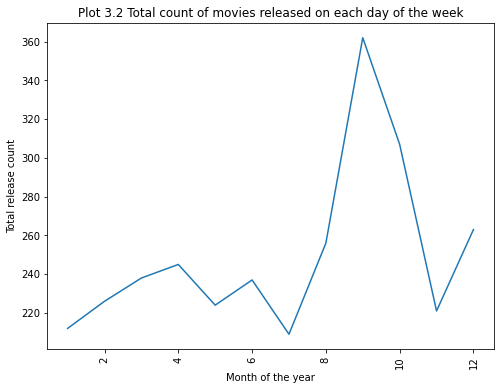

In [12]:
# plot of the total count of movies released on each day of the week
sorter_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
release_each_month = train.groupby('release_month').size().reset_index().rename(columns={0:'count'})
sorterIndex = dict(zip(sorter_day,range(len(sorter_day))))
release_each_month['release_month_id'] = release_each_month['release_month']
release_each_month['release_month_id'] = release_each_month['release_month_id'].map(sorterIndex)
release_each_month.sort_values('release_month_id', inplace=True)
plt.figure(figsize= (8,6))
plt.plot(release_each_month['release_month'],release_each_month['count'])
plt.title('Plot 3.2 Total count of movies released on each day of the week')
plt.xticks(rotation='vertical')
plt.xlabel('Month of the year')
plt.ylabel('Total release count')
plt.show()

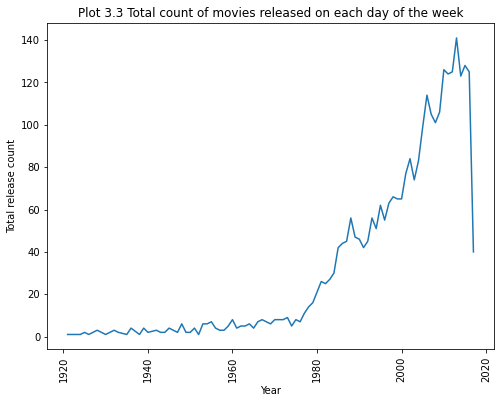

In [13]:
# plot of the total count of movies released on each day of the week

release_each_year = train.groupby('release_year').size().reset_index().rename(columns={0:'count'})
plt.figure(figsize= (8,6))
plt.plot(release_each_year['release_year'],release_each_year['count'])
plt.title('Plot 3.3 Total count of movies released on each day of the week')
plt.xticks(rotation='vertical')
plt.xlabel('Year')
plt.ylabel('Total release count')
plt.show()

### Observations
- From plot 3.1 we can see that the majority of the movies are released on friday of the week. The releases increases as we go     from monday to friday and plummets on saturday and sunday.
- From plot 3.2 we can observe that movies were released the most during the month of September and least released in July and     January.
- From plot 3.3 we can observe that only 5-13 movies were released every year from 1920 to 1978. After that the number of releases per year increased sharply, reaching maximum in the year

# Part 4 - Cast Power

In [14]:


from collections import Counter

# Labelling null cast as 3
train.loc[train['cast_gender']=="",'cast_gender'] = '3'
test.loc[test['cast_gender']=="",'cast_gender'] = '3'

# Number of cast with gender 0
train['cast_gender_0'] = train['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="0" ]))
test['cast_gender_0'] = test['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="0" ]))

# Number of cast with gender 1
train['cast_gender_1'] = train['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="1" ]))
test['cast_gender_1'] = test['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="1" ]))

# Number of cast with gender 2
train['cast_gender_2'] = train['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="2" ]))
test['cast_gender_2'] = test['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="2" ]))

# Number of cast with gender 3
train['cast_gender_None'] = train['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="3" ]))
test['cast_gender_None'] = test['cast_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="3" ]))

# Total Number of casts in the movie
train['total_number_cast'] = train['cast_gender_0'] + train['cast_gender_1'] + train['cast_gender_2']
test['total_number_cast'] = test['cast_gender_0'] + test['cast_gender_1'] + test['cast_gender_2']

In [15]:
# Calculating the cast power of a movie by calculating two things
# 1. Total Star Power is the sum of the total number of movies acted by every actor in that movie
# 2. Average Star Power is the total star power divided by the number of actors in that movie. This feature
#    tells you the weight of cast in the movie by knowing the experience of the every actor in the movie. 

# Calculate how many movies each actor is featured in.
all_casts = [j   for i in train['cast_names'] for j in i.split(',') if j!='' and j!=' Jr.' ] 
all_casts_count = Counter(all_casts)

# Calculate the total star power and average star power.
train['total_star_power'] = train['cast_names'].apply(lambda x: sum([ all_casts_count[i] for i in x.split(',')]))
train['average_star_power'] = train['total_star_power']/train['total_number_cast']

all_casts_count = Counter(all_casts)
test['total_star_power'] = test['cast_names'].apply(lambda x: sum([ all_casts_count[i] for i in x.split(',')]))
test['average_star_power'] = test['total_star_power']/test['total_number_cast']

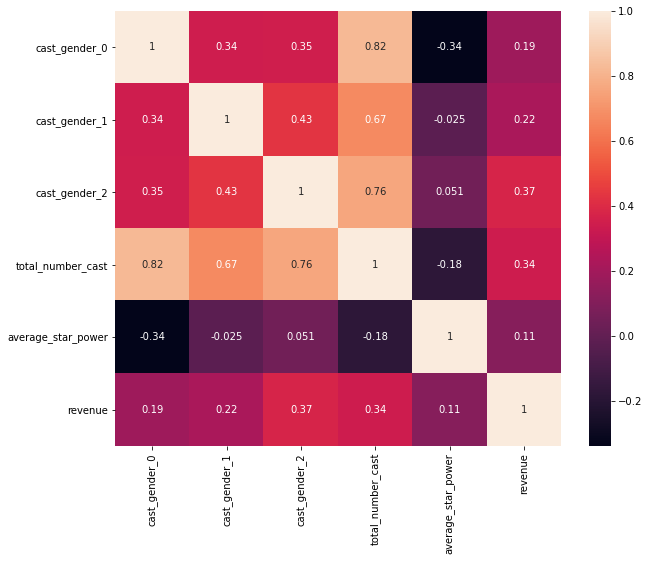

In [16]:
# Finding the Correlation between the revenue and features related to the cast.
cast_revenue = train[['cast_gender_0','cast_gender_1','cast_gender_2','total_number_cast','average_star_power','revenue']] 
np.random.seed(0)
import seaborn as sns 
plt.figure(figsize=(10,8))
ax = sns.heatmap(cast_revenue.corr(),annot=True)

### Observation
- The correlation heatmap shows that when there are more cast with gender 2, the more the revenue the movie is going to get than increasing cast of other genders.
- We also observe that the average star power is not highly correlated with the revenue of a movie.
- The Average star power is negatively correlated with the number of cast with gender 0
- The Avergae star power is negatively correlated with the total number of cast in the movie

# Part 5 - External Dataset

### External dataset with three extra columns
1. Another popularity measure of the movie.
2. Rating of the movie.
3. Total Votes cast for the rating of the movie.

These features are merged with the original dataset with the help of the imdb_id

In [17]:
# TODO: code for integrating external dataset

external_train = pd.read_csv('tmdb-box-office-prediction/TrainAdditionalFeatures.csv')
external_test = pd.read_csv('tmdb-box-office-prediction/TestAdditionalFeatures.csv')

train = train.merge(external_train, on = "imdb_id",how='left')
test = test.merge(external_test, on = "imdb_id",how='left')

In [18]:
# Revenue and budget of few missing values
# Source = https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat#Feature-Engineering-&-Prediction

train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30


In [19]:
external_train.head()

,imdb_id,popularity2,rating,totalVotes
0,tt0169547,16.217,8.0,6016.0
1,tt0119116,26.326,7.4,5862.0
2,tt0325980,28.244,7.7,11546.0
3,tt0266697,18.202,7.9,8638.0
4,tt0418763,9.653,6.6,1201.0


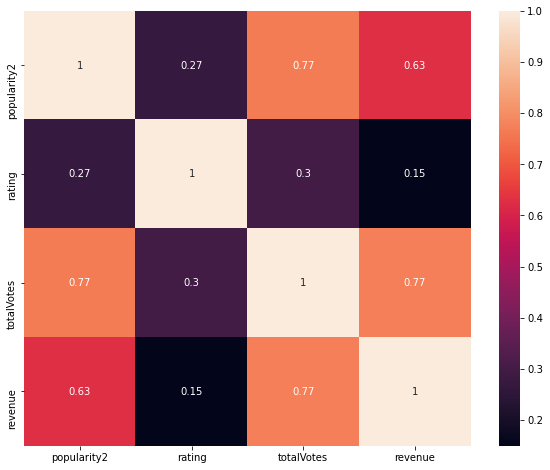

In [20]:
extra_features_df = train[['popularity2','rating','totalVotes','revenue']]
extra_features_df_corr = extra_features_df.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(extra_features_df_corr,annot=True)

### Observations

- From the correlation heat map we can observe that the total votes and popularity2 measure is very important and they are highly positively correlated with the revenue of the movie.
- The Rating of the movie is not highly correlated with the revenue of the movie.
- The total votes is very highly correlated with the revenue of the movie.

So the addition of the external dataset helps a lot in the prediction of the revenue.

As the budget is a very important field in predicting the revenue, the filling of the budget helps predicting the revenue.

# Part 6 - Informative Plots

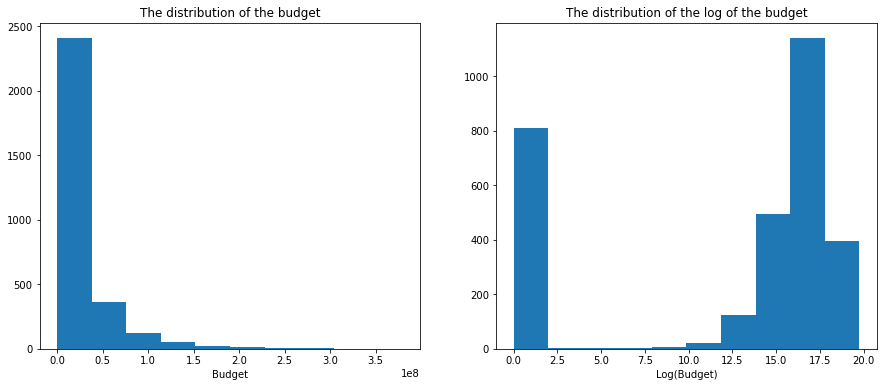

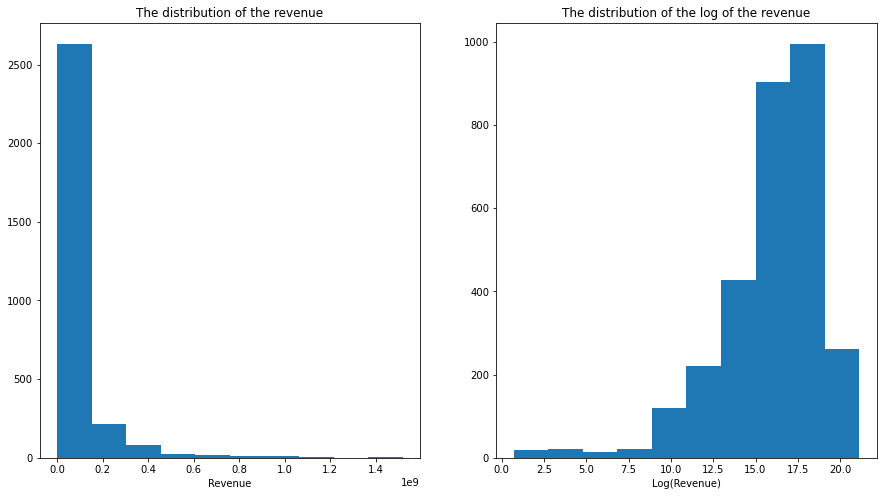

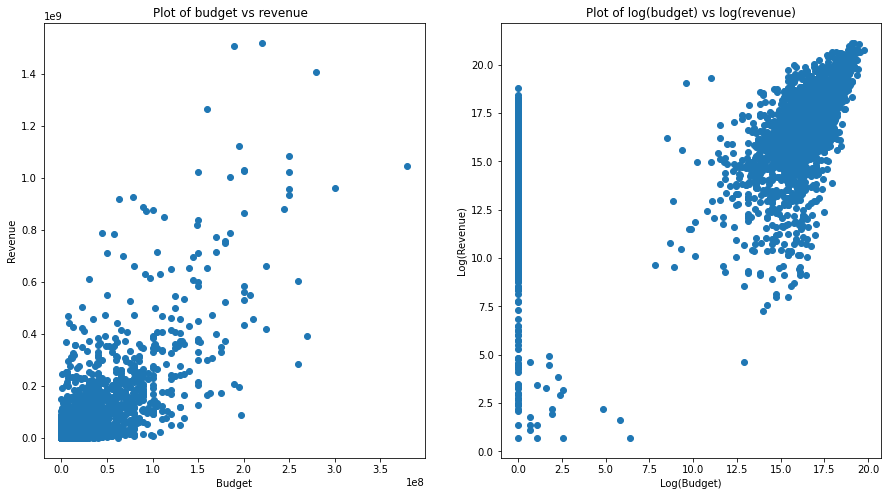

In [21]:
# TODO: code for producing informative plots
# Relation between budget and revenue
import math

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.title.set_text('The distribution of the budget') 
ax2.title.set_text('The distribution of the log of the budget')
ax1.hist(train['budget'])
ax1.set_xlabel('Budget')
ax2.hist(train['budget'].apply(math.log1p))
ax2.set_xlabel('Log(Budget)')

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
ax1.title.set_text('The distribution of the revenue') 
ax2.title.set_text('The distribution of the log of the revenue')
ax1.set_xlabel('Revenue')
ax2.set_xlabel('Log(Revenue)')
ax1.hist(train['revenue'])
ax2.hist(train['revenue'].apply(math.log1p))

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
ax1.title.set_text('Plot of budget vs revenue  ') 
ax2.title.set_text('Plot of log(budget) vs log(revenue)')
ax1.set_xlabel('Budget')
ax2.set_xlabel('Log(Budget)')
ax1.set_ylabel('Revenue')
ax2.set_ylabel('Log(Revenue)')
ax1.scatter(train['budget'],train['revenue'])
ax2.scatter(train['budget'].apply(math.log1p),train['revenue'].apply(math.log1p))



### Observations
- The plots of log(budget) and log(revenue) gives more information than the budget and revenue respectively.
- From the plot of log(budget) vs log(revenue) we can see that the revenue also increases with the budget of the movie.

Text(0, 0.5, 'Revenue')

<Figure size 720x576 with 0 Axes>

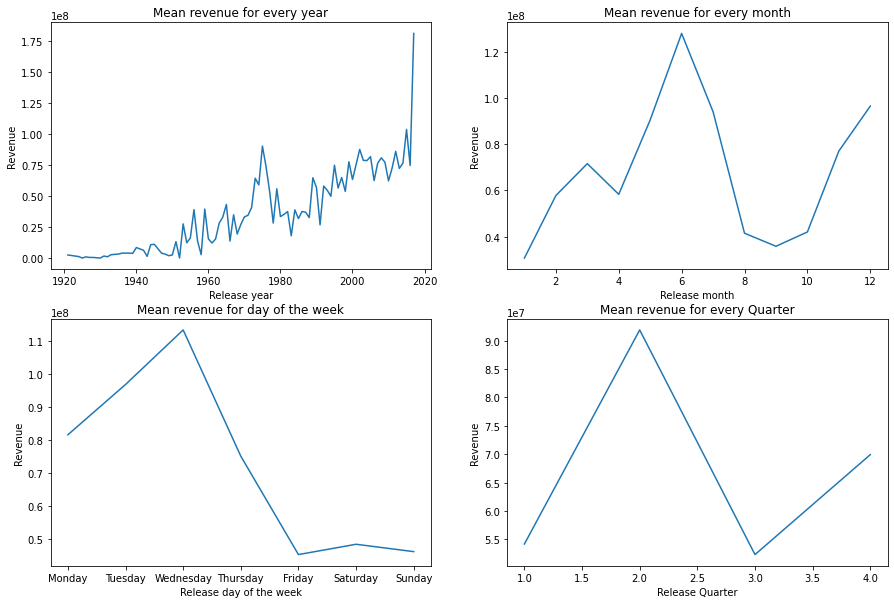

In [22]:
# revenue by year
plt.figure(figsize=(10,8))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)

fig.set_figheight(10)
fig.set_figwidth(15)
mean_revenue_by_year = train.groupby('release_year')['revenue'].mean().reset_index()
ax1.plot(mean_revenue_by_year['release_year'], mean_revenue_by_year['revenue'])
ax1.title.set_text('Mean revenue for every year')
ax1.set_xlabel('Release year')
ax1.set_ylabel('Revenue')

mean_revenue_by_month = train.groupby('release_month')['revenue'].mean().reset_index()
ax2.plot(mean_revenue_by_month['release_month'], mean_revenue_by_month['revenue'])
ax2.title.set_text('Mean revenue for every month')
ax2.set_xlabel('Release month')
ax2.set_ylabel('Revenue')

sorter_day = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_revenue_by_day = train.groupby('release_day')['revenue'].mean().reset_index()
sorterIndex = dict(zip(sorter_day,range(len(sorter_day))))
mean_revenue_by_day['release_day_id'] = mean_revenue_by_day['release_day']
mean_revenue_by_day['release_day_id'] = mean_revenue_by_day['release_day_id'].map(sorterIndex)
mean_revenue_by_day.sort_values('release_day_id', inplace=True)
ax3.plot(mean_revenue_by_day['release_day'], mean_revenue_by_day['revenue'])
ax3.title.set_text('Mean revenue for day of the week')
ax3.set_xlabel('Release day of the week')
ax3.set_ylabel('Revenue')

mean_revenue_by_quarter = train.groupby('release_quarter')['revenue'].mean().reset_index()
ax4.plot(mean_revenue_by_quarter['release_quarter'], mean_revenue_by_quarter['revenue'])
ax4.title.set_text('Mean revenue for every Quarter')
ax4.set_xlabel('Release Quarter')
ax4.set_ylabel('Revenue')



### Observations
- The mean revenue every year has been continuously increasing since 1920 and there was an unusual spike in the revenue in the 1970's.
- Mean revenue is the highest in the month of June and lowest in January.
- Mean revenue is the highest on wednesday and lowest during the weekends.
- Mean revenue is the highest in the second quarter and the least in the third quarter.

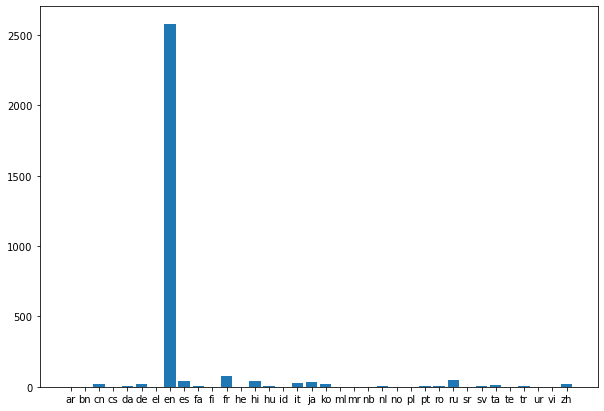

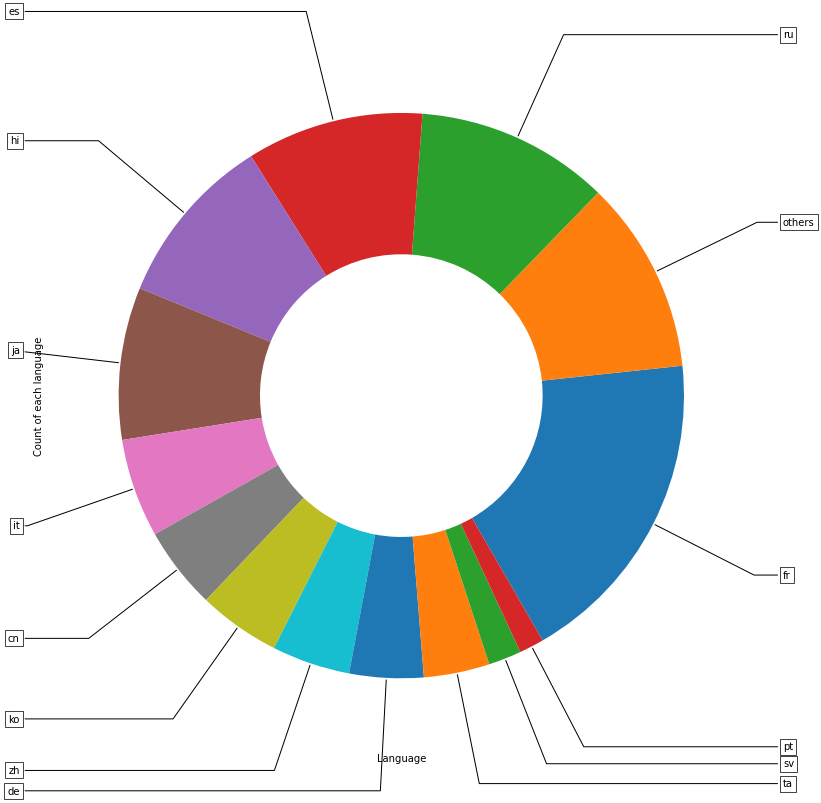

In [23]:
language_count = train.groupby('original_language').size().reset_index().rename(columns={0:'count'})
fig = plt.figure(figsize =(10, 7)) 
plt.bar(language_count['original_language'],language_count['count'])  
plt.show() 
fig, ax = plt.subplots(figsize=(16, 13), subplot_kw=dict(aspect="equal"))
ax.set_xlabel('Language')
ax.set_ylabel('Count of each language')

language_count = language_count[language_count['original_language']!='en']
language_count.sort_values('count',inplace=True,ascending=False)
language_count = language_count.reset_index()
language_count.loc[language_count.index>12,'original_language'] = 'others'
language_count = language_count.groupby('original_language')['count'].sum().reset_index()
language_count.sort_values('count',inplace=True,ascending=False)
languages = language_count['original_language'].values

wedges, texts = ax.pie(language_count['count'], wedgeprops=dict(width=0.5), startangle=-60)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(languages[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

### Observations
- More than 90% of the movies released are english.
- The pie chart shows the percentage of movies released in languages other than english.

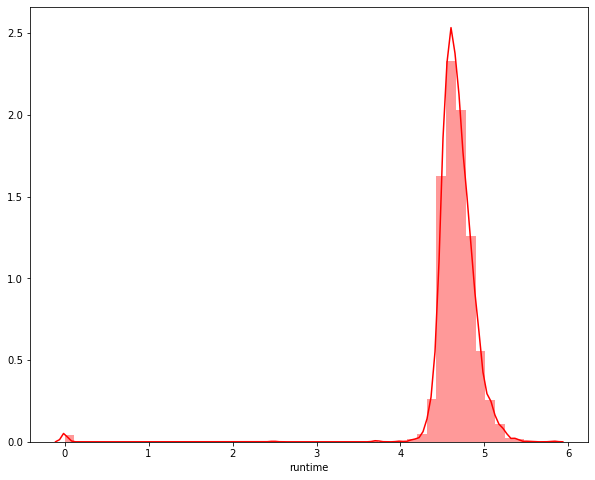

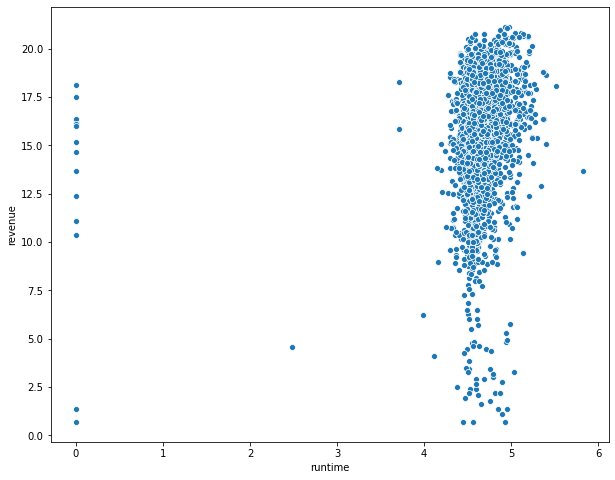

In [24]:
train['runtime'] = train['runtime'].fillna(0)
plt.figure(figsize=(10,8))
sns.distplot(np.log1p(train['runtime'].fillna(0)),color='r')
plt.figure(figsize=(10,8))
sns.scatterplot(train['runtime'].fillna(0).apply(math.log1p),train['revenue'].apply(math.log1p))

### Observations
- The runtime feature follows a normal distribution. It can be seen from the first plot.
- The runtime vs revenue is not very much informative. We can infer that movies which are longest gets more revenue.

In [25]:
train['crew_department_actors'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Actors" ]))
train['crew_department_art'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Art" ]))
train['crew_department_camera'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Camera" ]))
train['crew_department_costume'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Costume & Make-Up" ]))
train['crew_department_crew'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Crew" ]))
train['crew_department_directing'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Directing" ]))
train['crew_department_editing'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Editing" ]))
train['crew_department_lighting'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Lighting" ]))
train['crew_department_production'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Production" ]))
train['crew_department_sound'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Sound" ]))
train['crew_department_visualeffects'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Visual Effects" ]))
train['crew_department_writing'] = train['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Writing" ]))

test['crew_department_actors'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Actors" ]))
test['crew_department_art'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Art" ]))
test['crew_department_camera'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Camera" ]))
test['crew_department_costume'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Costume & Make-Up" ]))
test['crew_department_crew'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Crew" ]))
test['crew_department_directing'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Directing" ]))
test['crew_department_editing'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Editing" ]))
test['crew_department_lighting'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Lighting" ]))
test['crew_department_production'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Production" ]))
test['crew_department_sound'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Sound" ]))
test['crew_department_visualeffects'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Visual Effects" ]))
test['crew_department_writing'] = test['crew_department'].apply(lambda x: sum([1 for k in x.split(',') if k=="Writing" ]))

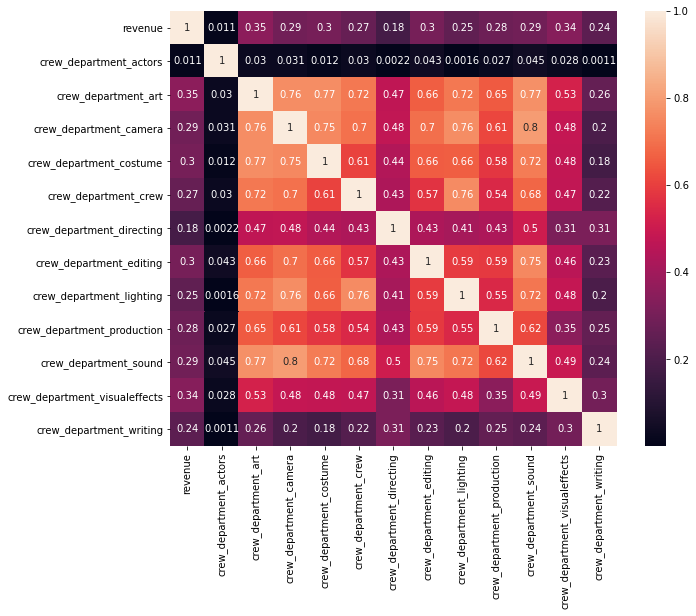

In [26]:
crew_department = train[['revenue','crew_department_actors','crew_department_art','crew_department_camera','crew_department_costume','crew_department_crew','crew_department_directing','crew_department_editing','crew_department_lighting','crew_department_production','crew_department_sound','crew_department_visualeffects','crew_department_writing']]
plt.figure(figsize=(10,8))
ax = sns.heatmap(crew_department.corr(),annot=True)

### Observations
- From the correlation heatmap, we can see that the more the number of crew in art and visual effects in a movie, the revenue is   going to increase the highest accordingly. 
- The number of actors in the crew is the least correlated with the revenue of the movie.

# Part 7 - Pairwise Pearson Correlation

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'collection_name', 'production_companies_name',
       'production_country_name', 'language_spoken', 'keywords', 'cast_gender',
       'crew_department', 'crew_gender', 'cast_names', 'cast_roles',
       'release_year', 'release_month', 'release_day', 'release_quarter',
       'cast_gender_0', 'cast_gender_1', 'cast_gender_2', 'cast_gender_None',
       'total_number_cast', 'total_star_power', 'average_star_power',
       'popularity2', 'rating', 'totalVotes', 'crew_department_actors',
       'crew_department_art', 'crew_department_camera',
       'crew_department_costume', 'crew_department_crew',
       'crew_department_directing',

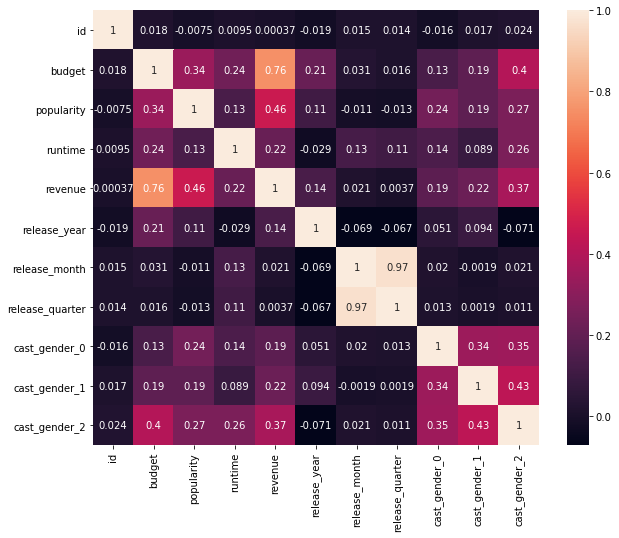

In [27]:
# TODO: code for pairwise Pearson correlation
# crew_department = train[['revenue','crew_department_actors','crew_department_art','crew_department_camera','crew_department_costume','crew_department_crew','crew_department_directing','crew_department_editing','crew_department_lighting','crew_department_production','crew_department_sound','crew_department_visualeffects','crew_department_writing']]
print(train.columns)
correlation_columns = train.columns[:40]
correlation = train[correlation_columns]
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation.corr(),annot=True)

### Observations
- The Revenue is most correlated with the Budget and popularity of the movie.
- The id is the least correlated of the all the features in th heatmap.

# Part 8 - Regression and Permutation Test

0.32673267326732675
0.009900990099009901
0.009900990099009901


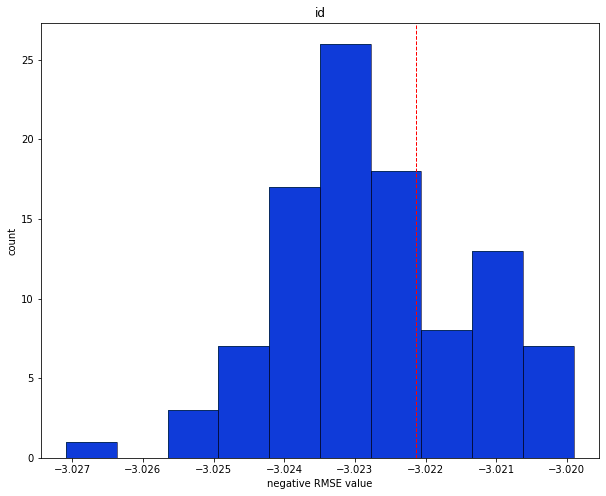

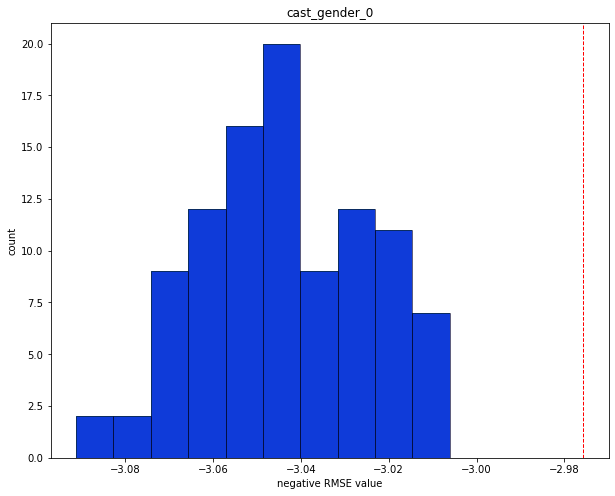

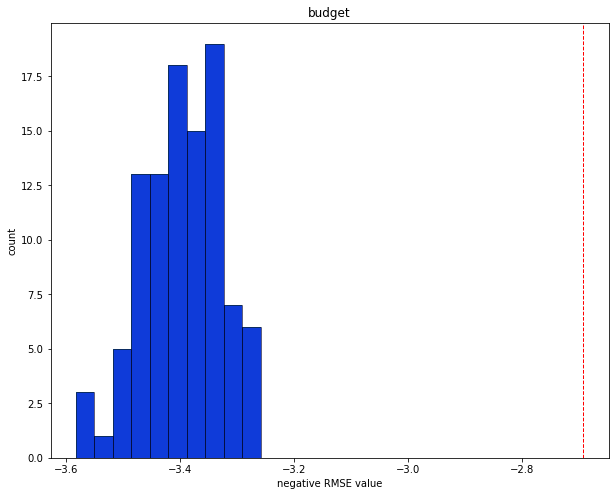

In [28]:
# TODO: code for your regression models and permutation tests

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

def permutation_test(actual,predicted,column):
    
    rmse_obs =  math.sqrt(mean_squared_error(actual,predicted))
    
    rmse_permutations = []
    greater_rmse_count = 0
    
    
    for i in range(100):
        np.random.shuffle(predicted)
        rmse_shuffle = math.sqrt(mean_squared_error(actual,predicted))
        rmse_permutations.append(-1*rmse_shuffle)
        if -1*rmse_shuffle >= -1*rmse_obs:
            greater_rmse_count+=1
            
    p_value = (greater_rmse_count+1)/101
    print(p_value)
    plt.figure(figsize=(10,8))
    plt.title(column)
    plt.xlabel('negative RMSE value')
    plt.ylabel('count')
    
    plt.hist(np.array(rmse_permutations))
    plt.hist(np.array(rmse_permutations),  edgecolor='k', color='b',alpha=0.5)
    plt.axvline(-1*rmse_obs, color='r', linestyle='dashed', linewidth=1)
       
    
traindata,valdata = train_test_split(train,test_size=0.1,random_state=0)
test_columns = ['id','cast_gender_0','budget']
for column in test_columns:

    X_train = traindata[column]
    y_train = traindata['revenue']

    X_val = valdata[column]
    y_val = valdata['revenue']    

    log_revenue = y_train.apply(math.log1p).values.reshape(-1, 1)
    reg = LinearRegression().fit(X_train.values.reshape(-1, 1), log_revenue)
    pred = reg.predict(X_val.values.reshape(-1, 1))

    actual = y_val.apply(math.log1p).values.reshape(-1, 1)
    predicted = pred
    permutation_test(actual,predicted,column)



### Observation
- In the plot of ID variable, the observed rmse value rank is in between the all the random permutations, whcih means that the ID variable is not an important variable. The p-value is 0.2673, which is greater than the 0.05 value. So we accept the null hypothesis.
- In the plot of cast_gender_0 variable, the observed rmse value rank is first in the all the random permutations, whcih means that the cast_gender_0 is an important variable. The p-value is 0.00990, which is less than the 0.05 value. So we reject the null hypothesis. But there is not a lot of difference in the rmse value of the permutations and the observed rmse. So it may not be the best features in the lot.
- In the plot of budget variable, the observed rmse value rank is first in the all the random permutations, whcih means that the cast_gender_0 is an important variable. The p-value is 0.00990, which is less than the 0.05 value. So we reject the null hypothesis. There is a lot of difference in the rmse value of the permutations and the observed rmse. So it may be one of the best features in the lot.

# Part 9 - Predicton

In [29]:
# TODO: code for your prediction models

def generate_features(df):
    df['rating'] = df['rating'].fillna(df['rating'].mean())
    df['totalVotes'] = df['totalVotes'].fillna(df['totalVotes'].mean())
    df['budget_by_rating'] = df['budget']/df['rating']
    df['runtime_by_rating'] = df['runtime']/df['rating']
    df['budget_by_totalvotes'] = df['budget']/df['totalVotes']
    df['popularity_mean_year'] = df['popularity'] / df.groupby("release_year")["popularity"].transform('mean')
    df['budget_by_runtime'] = df['budget']/df['runtime'] 
    df['budget_by_popularity'] = df['budget']/df['popularity']
    df['totalvotes_by_popularity'] = df['totalVotes']/df['popularity']
    df['rating_by_popularity'] = df['rating']/df['popularity']
    df['rating_by_totalvotes'] = df['totalVotes']/df['rating']
    df.loc[df['crew_gender']=="",'crew_gender'] = '3'
    df['crew_gender_0'] = df['crew_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="0" ]))
    df['crew_gender_1'] = df['crew_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="1" ]))
    df['crew_gender_2'] = df['crew_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="2" ]))
    df['crew_gender_None'] = df['crew_gender'].apply(lambda x: sum([1 for k in x.split(',') if k=="3" ]))
    df['total_number_crew'] = df['crew_gender_0'] + df['crew_gender_1'] + df['crew_gender_2']
    df['title_number_of_words'] = df['title'].str.split().agg(len)
    df['overview_number_of_words'] = df['overview'].str.split().agg(len)
    df['tagline_number_of_words'] = df['tagline'].str.split().agg(len)
    df['production_companies_count'] =  df['production_companies_name'].str.split(',').agg(len)
    df['production_country_count'] = df['production_country_name'].str.split(',').agg(len)
    df['runtime_by_year'] = df.groupby('release_year')['runtime'].transform(lambda x:x.mean())
    df['popularity_by_year'] =  df.groupby('release_year')['popularity'].transform(lambda x:x.mean())
    df['budget_by_year'] = df.groupby('release_year')['budget'].transform(lambda x:x.mean())
    df['votes_by_year'] =  df.groupby('release_year')['totalVotes'].transform(lambda x:x.mean())
    df['homepage_exist'] = 1
    df.loc[df['homepage'].isna(),'homepage_exist'] = 0
    df['is_collection_name'] = 1
    df.loc[df['collection_name']=="",'is_collection_name'] = 0
    df['language_spoken_en'] = 0
    df.loc[df['language_spoken']=='en','language_spoken_en'] = 1
    
    genres = df['genres'].str.get_dummies(sep=',')
    release_day = df['release_day'].str.get_dummies(sep=',')
    
    df = pd.concat([df,release_day,genres],axis=1)
    df = df.fillna(0)
    df = df.drop(['id','belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline',
    'collection_name','production_companies_name','production_country_name','language_spoken',
    'keywords','cast_gender','crew_department','crew_gender','cast_names','cast_roles','release_day'
    ],axis=1)

    return df

train = generate_features(train)
train = train.drop(columns=['TV Movie'])
test = generate_features(test)


In [30]:
train.shape

(3000, 80)

In [31]:
test.shape

(4398, 79)

In [32]:
train_sub = train.drop(columns=['release_year', 'release_month','release_quarter', 'cast_gender_0', 'cast_gender_1', 'cast_gender_2','total_star_power','crew_gender_None'])
test_sub = test.drop(columns=['release_year', 'release_month','release_quarter', 'cast_gender_0', 'cast_gender_1', 'cast_gender_2','total_star_power','crew_gender_None'])

In [33]:
traindata, valdata = train_test_split(train,test_size=0.1,random_state=0)

In [34]:
X_train = traindata
y_train = traindata['revenue'].apply(math.log1p)
X_train.drop(columns=['revenue'],inplace=True)

X_val = valdata
y_val = valdata['revenue'].apply(math.log1p)
X_val.drop(columns=['revenue'],inplace=True)

X_test = test

In [35]:
import time
ts = time.time()

model = XGBRegressor(max_depth=5, 
                            objective='reg:linear', 
                            learning_rate=0.01, 
                            gamma=1.45, 
                            seed=1, 
                            subsample=1, 
                            colsample_bytree=0.5, 
                            silent=True,
                            n_estimators=10000, 
                            colsample_bylevel=0.5)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[11:58:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:58:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:15.60231	validation_1-rmse:15.71446
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:15.44990	validation_1-rmse:15.56251
[2]	validation_0-rmse:15.29894	validation_1-rmse:15.41133
[3]	validation_0-rmse:15.14927	validation_1-rmse:15.26300
[4]	validation_0-rmse:15.00120	validation_1-rmse

[130]	validation_0-rmse:4.61066	validation_1-rmse:4.75701
[131]	validation_0-rmse:4.57188	validation_1-rmse:4.71821
[132]	validation_0-rmse:4.53307	validation_1-rmse:4.67962
[133]	validation_0-rmse:4.49472	validation_1-rmse:4.64157
[134]	validation_0-rmse:4.45695	validation_1-rmse:4.60452
[135]	validation_0-rmse:4.41971	validation_1-rmse:4.56844
[136]	validation_0-rmse:4.38275	validation_1-rmse:4.53152
[137]	validation_0-rmse:4.34621	validation_1-rmse:4.49524
[138]	validation_0-rmse:4.30955	validation_1-rmse:4.45851
[139]	validation_0-rmse:4.27359	validation_1-rmse:4.42378
[140]	validation_0-rmse:4.23826	validation_1-rmse:4.38884
[141]	validation_0-rmse:4.20346	validation_1-rmse:4.35452
[142]	validation_0-rmse:4.16892	validation_1-rmse:4.32076
[143]	validation_0-rmse:4.13456	validation_1-rmse:4.28703
[144]	validation_0-rmse:4.10087	validation_1-rmse:4.25436
[145]	validation_0-rmse:4.06741	validation_1-rmse:4.22115
[146]	validation_0-rmse:4.03440	validation_1-rmse:4.18881
[147]	validati

[272]	validation_0-rmse:1.91470	validation_1-rmse:2.15156
[273]	validation_0-rmse:1.90789	validation_1-rmse:2.14590
[274]	validation_0-rmse:1.90169	validation_1-rmse:2.13976
[275]	validation_0-rmse:1.89549	validation_1-rmse:2.13414
[276]	validation_0-rmse:1.88908	validation_1-rmse:2.12851
[277]	validation_0-rmse:1.88272	validation_1-rmse:2.12326
[278]	validation_0-rmse:1.87696	validation_1-rmse:2.11804
[279]	validation_0-rmse:1.87082	validation_1-rmse:2.11306
[280]	validation_0-rmse:1.86460	validation_1-rmse:2.10755
[281]	validation_0-rmse:1.85868	validation_1-rmse:2.10253
[282]	validation_0-rmse:1.85301	validation_1-rmse:2.09749
[283]	validation_0-rmse:1.84767	validation_1-rmse:2.09287
[284]	validation_0-rmse:1.84224	validation_1-rmse:2.08776
[285]	validation_0-rmse:1.83621	validation_1-rmse:2.08230
[286]	validation_0-rmse:1.83098	validation_1-rmse:2.07753
[287]	validation_0-rmse:1.82553	validation_1-rmse:2.07269
[288]	validation_0-rmse:1.81975	validation_1-rmse:2.06775
[289]	validati

[414]	validation_0-rmse:1.46782	validation_1-rmse:1.82172
[415]	validation_0-rmse:1.46633	validation_1-rmse:1.82103
[416]	validation_0-rmse:1.46512	validation_1-rmse:1.82017
[417]	validation_0-rmse:1.46357	validation_1-rmse:1.81913
[418]	validation_0-rmse:1.46223	validation_1-rmse:1.81859
[419]	validation_0-rmse:1.46080	validation_1-rmse:1.81820
[420]	validation_0-rmse:1.45948	validation_1-rmse:1.81758
[421]	validation_0-rmse:1.45817	validation_1-rmse:1.81685
[422]	validation_0-rmse:1.45679	validation_1-rmse:1.81622
[423]	validation_0-rmse:1.45536	validation_1-rmse:1.81524
[424]	validation_0-rmse:1.45405	validation_1-rmse:1.81480
[425]	validation_0-rmse:1.45270	validation_1-rmse:1.81449
[426]	validation_0-rmse:1.45158	validation_1-rmse:1.81415
[427]	validation_0-rmse:1.45010	validation_1-rmse:1.81324
[428]	validation_0-rmse:1.44868	validation_1-rmse:1.81251
[429]	validation_0-rmse:1.44757	validation_1-rmse:1.81203
[430]	validation_0-rmse:1.44602	validation_1-rmse:1.81130
[431]	validati

[556]	validation_0-rmse:1.31522	validation_1-rmse:1.76149
[557]	validation_0-rmse:1.31447	validation_1-rmse:1.76098
[558]	validation_0-rmse:1.31356	validation_1-rmse:1.76090
[559]	validation_0-rmse:1.31273	validation_1-rmse:1.76064
[560]	validation_0-rmse:1.31147	validation_1-rmse:1.76042
[561]	validation_0-rmse:1.31062	validation_1-rmse:1.75996
[562]	validation_0-rmse:1.30959	validation_1-rmse:1.75988
[563]	validation_0-rmse:1.30829	validation_1-rmse:1.75870
[564]	validation_0-rmse:1.30747	validation_1-rmse:1.75881
[565]	validation_0-rmse:1.30660	validation_1-rmse:1.75874
[566]	validation_0-rmse:1.30581	validation_1-rmse:1.75774
[567]	validation_0-rmse:1.30516	validation_1-rmse:1.75748
[568]	validation_0-rmse:1.30425	validation_1-rmse:1.75728
[569]	validation_0-rmse:1.30320	validation_1-rmse:1.75692
[570]	validation_0-rmse:1.30251	validation_1-rmse:1.75683
[571]	validation_0-rmse:1.30193	validation_1-rmse:1.75677
[572]	validation_0-rmse:1.30139	validation_1-rmse:1.75660
[573]	validati

12.570443153381348

Text(0.5, 1.0, 'Top 20 Features')

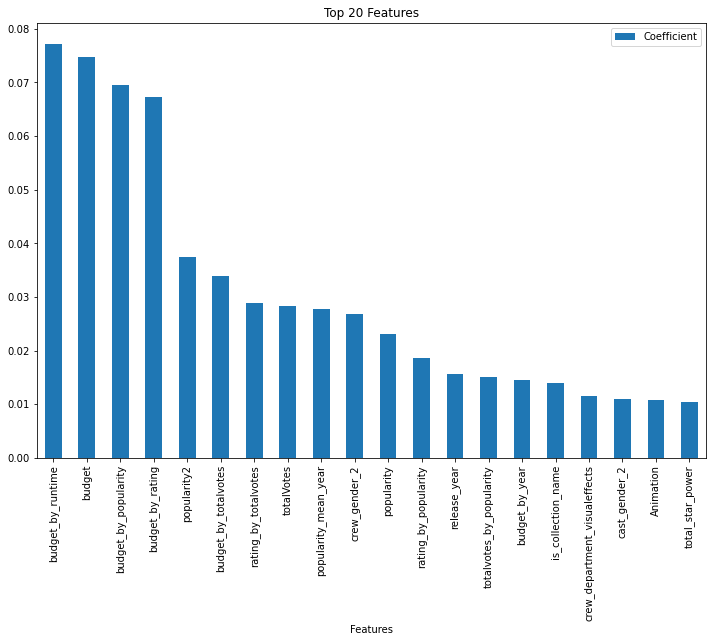

In [36]:
coeff_df = pd.DataFrame(model.feature_importances_,X_train.columns,columns=['Coefficient'])
fig, ax = plt.subplots(1,1,figsize=(12,8))
coeff_df.sort_values(by='Coefficient',ascending=False).head(20).plot(kind='bar',ax=ax)
plt.xlabel('Features')
plt.title('Top 20 Features')

In [37]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from c:\vignesh\quantarium\tensorflow\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\VIGNES~1\AppData\Local\Temp\tmplrastk5o
  JVM stdout: C:\Users\VIGNES~1\AppData\Local\Temp\tmplrastk5o\h2o_Vignesh_Ram_Nithin_started_from_python.out
  JVM stderr: C:\Users\VIGNES~1\AppData\Local\Temp\tmplrastk5o\h2o_Vignesh_Ram_Nithin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_Vignesh_Ram_Nithin_hxxsh6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.497 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [38]:
X_train.columns.values

array(['budget', 'popularity', 'release_year', 'release_month',
       'release_quarter', 'cast_gender_0', 'cast_gender_1',
       'cast_gender_2', 'cast_gender_None', 'total_number_cast',
       'total_star_power', 'average_star_power', 'popularity2', 'rating',
       'totalVotes', 'crew_department_actors', 'crew_department_art',
       'crew_department_camera', 'crew_department_costume',
       'crew_department_crew', 'crew_department_directing',
       'crew_department_editing', 'crew_department_lighting',
       'crew_department_production', 'crew_department_sound',
       'crew_department_visualeffects', 'crew_department_writing',
       'budget_by_rating', 'runtime_by_rating', 'budget_by_totalvotes',
       'popularity_mean_year', 'budget_by_runtime',
       'budget_by_popularity', 'totalvotes_by_popularity',
       'rating_by_popularity', 'rating_by_totalvotes', 'crew_gender_0',
       'crew_gender_1', 'crew_gender_2', 'crew_gender_None',
       'total_number_crew', 'title_numbe

In [39]:
train_automl = train.copy()
train_automl['revenue'] = train_automl['revenue'].apply(math.log1p)
train_automl['budget'] = train_automl['budget'].apply(math.log1p)

In [40]:
y = "revenue"
x = X_train.columns.values.tolist()
h2o_train = h2o.H2OFrame(train_automl)
aml = H2OAutoML(max_models = 30, max_runtime_secs=300, seed = 1)
aml.train(x = x, y = y, training_frame = h2o_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
11:58:54.791: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [41]:
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows) # Entire leaderboard


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_2_AutoML_20201015_115854,3.67157,1.91613,3.67157,1.23228,0.185069
GBM_3_AutoML_20201015_115854,3.686,1.9199,3.686,1.22353,0.184325
GBM_grid__1_AutoML_20201015_115854_model_1,3.69163,1.92136,3.69163,1.2335,0.184705
GBM_4_AutoML_20201015_115854,3.70539,1.92494,3.70539,1.23041,0.184362
GBM_5_AutoML_20201015_115854,3.93471,1.98361,3.93471,1.24033,0.197043
GBM_grid__1_AutoML_20201015_115854_model_9,3.96358,1.99087,3.96358,1.25855,0.196728
GBM_grid__1_AutoML_20201015_115854_model_6,3.98059,1.99514,3.98059,1.27077,0.194808
GBM_1_AutoML_20201015_115854,3.98555,1.99638,3.98555,1.27113,0.19285
GBM_grid__1_AutoML_20201015_115854_model_11,4.00782,2.00195,4.00782,1.2611,0.196346
GBM_grid__1_AutoML_20201015_115854_model_4,4.01032,2.00258,4.01032,1.28239,0.194736


In [42]:
model = aml.leader
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20201015_115854


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,55.0,55.0,40515.0,7.0,7.0,7.0,20.0,94.0,53.98182




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.1817278223645786
RMSE: 1.087073052910695
MAE: 0.7130569661060969
RMSLE: 0.11578591984524463
Mean Residual Deviance: 1.1817278223645786

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3.671569259120794
RMSE: 1.9161339355903058
MAE: 1.2322837552598982
RMSLE: 0.18506949234395775
Mean Residual Deviance: 3.671569259120794

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.2322837,0.037388064,1.2371048,1.2421647,1.2231901,1.1776521,1.2813071
1,mean_residual_deviance,3.6715693,0.30603445,3.853446,3.4342017,3.4294498,3.5184653,4.1222835
2,mse,3.6715693,0.30603445,3.853446,3.4342017,3.4294498,3.5184653,4.1222835
3,r2,0.5997641,0.029635869,0.5815385,0.6246956,0.6228903,0.5567448,0.6129513
4,residual_deviance,3.6715693,0.30603445,3.853446,3.4342017,3.4294498,3.5184653,4.1222835
5,rmse,1.9148309,0.0789903,1.9630196,1.8531599,1.8518773,1.8757572,2.0303407
6,rmsle,0.18427187,0.019189738,0.18867405,0.16925368,0.1804484,0.16794175,0.21504144



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-15 11:59:19,3.566 sec,0.0,3.035282,2.231081,9.212934
1,,2020-10-15 11:59:19,3.724 sec,5.0,2.309855,1.622497,5.335429
2,,2020-10-15 11:59:19,3.863 sec,10.0,1.897513,1.284915,3.600557
3,,2020-10-15 11:59:19,4.049 sec,15.0,1.675885,1.099032,2.808589
4,,2020-10-15 11:59:19,4.233 sec,20.0,1.512733,0.981766,2.288361
5,,2020-10-15 11:59:20,4.348 sec,25.0,1.417589,0.912270,2.009559
6,,2020-10-15 11:59:20,4.451 sec,30.0,1.319302,0.854338,1.740558
7,,2020-10-15 11:59:20,4.545 sec,35.0,1.251415,0.815131,1.566040
8,,2020-10-15 11:59:20,4.642 sec,40.0,1.195747,0.779439,1.429810
9,,2020-10-15 11:59:20,4.731 sec,45.0,1.149795,0.749881,1.322028



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,budget,44987.667969,1.000000,0.374683
1,rating_by_totalvotes,7143.132324,0.158780,0.059492
2,budget_by_rating,6280.717285,0.139610,0.052309
3,budget_by_runtime,5757.585449,0.127981,0.047952
4,release_year,4793.839844,0.106559,0.039926
5,totalVotes,4209.670898,0.093574,0.035061
6,popularity2,4000.493408,0.088924,0.033318
7,popularity_mean_year,3798.632080,0.084437,0.031637
8,popularity,3589.068848,0.079779,0.029892
9,rating,3158.256836,0.070203,0.026304



See the whole table with table.as_data_frame()


In [43]:
pred = model.predict(h2o.H2OFrame(test)).as_data_frame().values.ravel().tolist()

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [44]:
df_test = pd.DataFrame(columns=['id','revenue'])
# pred = model.predict(test)
df_test['revenue'] = np.expm1(pred)
df_test['id'] = test.index
df_test['id'] = df_test['id']+3001
df_test.to_csv('submission15.csv',index=None)

### Observations

The features used for the dataset are
-  'release_year', 'release_month', 'release_quarter', 'cast_gender_0', 'cast_gender_1', 'cast_gender_2', 'cast_gender_None',      'total_number_cast', 'total_star_power', 'average_star_power', 'popularity2', 'rating','totalVotes','crew_department_actors',    'crew_department_art','crew_department_camera', 'crew_department_costume',
   'crew_department_crew', 'crew_department_directing','crew_department_editing', 'crew_department_lighting',
   'crew_department_production', 'crew_department_sound', 'crew_department_visualeffects', 'crew_department_writing',
   'budget_by_rating', 'runtime_by_rating', 'budget_by_totalvotes','popularity_mean_year', 'budget_by_runtime',         '      
   'budget_by_popularity', 'totalvotes_by_popularity', 'rating_by_popularity', 'rating_by_totalvotes', 'crew_gender_0',  
   'crew_gender_1','crew_gender_2', 'crew_gender_None', 'total_number_crew','title_number_of_words', 
   'overview_number_of_words','tagline_number_of_words', 'production_companies_count', 'production_country_count', 
   'runtime_by_year', 'popularity_by_year','budget_by_year', 'votes_by_year', 'homepage_exist',
   'is_collection_name', 'language_spoken_en', 'Friday', 'Monday','Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 
   'Action','Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama','Family', 'Fantasy', 'Foreign', 'History', 
   'Horror', 'Music', 'Mystery','Romance', 'Science Fiction', 'Thriller', 'War', 'Western'

The main features one hot encoded are
- Release day of the week
- Crew Department
- Genre of the movie
- Cast Gender
- Crew Gender 

The features that were engineered manually are
- release_year : year of release of the movie
- release_month : month of release of the movie
- release_quarter : quarter of release of movie
- total_number_cast : total number of cast in the movie
- budget_by_rating : ratio of budget and rating
- runtime_by_rating : ratio of runtime and rating
- budget_by_popularity : ratio of budget and popularity
- totalvotes_by_popularity : ratio of totalvotes and popularity
- rating_by_popularity : ratio of rating and probability
- rating_by_totalvotes : ratio of rating and totalvotes
- overview_number_of_words : total number of words in overview
- tagline_number_of_words : total number of words in tagline
- production_companies_count : count of production companies
- production_country_count : count of production country
- runtime_by_year : ratio of runtime by year
- popularity_by_year : ratio of runtime by year
- budget_by_year : ratio of budget by year
- votes_by_year : ratio of votes by year
- homepage_exist : (0/1) if homepage exists
- is_collection_name : (0/1) if collection name exists
- language_spoken_en : language of the movie


The features which were taken from the tasks are
- total_star_power
- average_star_power
- popularity2 
- rating
- totalVotes

I trained two models with the features engineered above.

**XGBOOST** <br>
After finetuning the model for almost 20 times for the right parameters of the XGBoost model. The best model produced a 
train-rmse:1.25711 and validation-rmse:1.74617

**AUTOML** <br>
The automl was used to find the optimal model with optimal hyper parameters. The H2O automl was used to get different models with different hyperparameters. The optimal model which was obtained was with rmse of 1.91613 on the validation fold.